Install Required Libraries

In [2]:
!pip install -q xgboost joblib

Import Libraries


In [3]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


Load Dataset

In [4]:
df = pd.read_csv("preprocessed.csv")
print("Dataset loaded:", df.shape)


Dataset loaded: (33306, 24)


Data Cleaning & Feature Selection

In [5]:
target_col = "habitable"

df = df.drop(columns=["habitability_score"], errors="ignore")

X = df.drop(columns=[target_col])
y = df[target_col]

X = X.select_dtypes(include=[np.number])
print("Features after cleaning:", X.shape)


Features after cleaning: (33306, 21)


Train–Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Define Models

In [7]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1,
    random_state=42,
    eval_metric="logloss"
)


Train Models

In [8]:
log_reg.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluation Function

In [9]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_prob))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Evaluate All Models

In [10]:
evaluate(log_reg, "Logistic Regression")
evaluate(dt, "Decision Tree")
evaluate(rf, "Random Forest")
evaluate(xgb, "XGBoost")



===== Logistic Regression =====
Accuracy : 0.9603722605824077
Precision: 0.6608695652173913
Recall   : 0.44970414201183434
F1-score : 0.5352112676056338
ROC-AUC  : 0.9872842819128033

Confusion Matrix:
 [[6246   78]
 [ 186  152]]

===== Decision Tree =====
Accuracy : 0.9983488441909336
Precision: 0.9939577039274925
Recall   : 0.9733727810650887
F1-score : 0.9835575485799701
ROC-AUC  : 0.9954463413538731

Confusion Matrix:
 [[6322    2]
 [   9  329]]

===== Random Forest =====
Accuracy : 0.9986490543380366
Precision: 0.9881305637982196
Recall   : 0.985207100591716
F1-score : 0.9866666666666667
ROC-AUC  : 0.9999022227711469

Confusion Matrix:
 [[6320    4]
 [   5  333]]

===== XGBoost =====
Accuracy : 0.9978985289702792
Precision: 0.9736842105263158
Recall   : 0.985207100591716
F1-score : 0.9794117647058823
ROC-AUC  : 0.9999242109517982

Confusion Matrix:
 [[6315    9]
 [   5  333]]


Overfitting / Underfitting Check

In [11]:
train_acc = accuracy_score(y_train, xgb.predict(X_train))
test_acc  = accuracy_score(y_test, xgb.predict(X_test))

print("\n===== OVERFITTING CHECK (XGBoost) =====")
print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)

if train_acc - test_acc > 0.02:
    print(" Possible Overfitting")
elif train_acc < 0.7 and test_acc < 0.7:
    print(" Possible Underfitting")
else:
    print(" Model is well balanced")



===== OVERFITTING CHECK (XGBoost) =====
Train Accuracy: 0.9999624680978833
Test Accuracy : 0.9978985289702792
 Model is well balanced


Save Final Model

In [12]:
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/random_forest.pkl")

print("Random Forest saved as models/random_forest.pkl")


Random Forest saved as models/random_forest.pkl


Generate & Save Predictions

In [13]:
df["habitability_score"] = xgb.predict_proba(X)[:, 1]

os.makedirs("data/processed", exist_ok=True)
df.to_csv("data/processed/habitability_predictions.csv", index=False)

print("Predictions saved as data/processed/habitability_predictions.csv")


Predictions saved as data/processed/habitability_predictions.csv


Feature Importance Table

In [14]:
fi = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print("Top 10 Important Features:")
print(fi.head(10))


Top 10 Important Features:
                  feature  importance
0           planet_radius    0.901528
3         semi_major_axis    0.020125
2          orbital_period    0.016228
6               star_temp    0.012779
10      orbital_stability    0.012560
9   stellar_compatibility    0.011186
8        star_metallicity    0.009845
7         star_luminosity    0.009742
5          planet_density    0.004690
14           star_class_G    0.000630


Feature Importance Plot

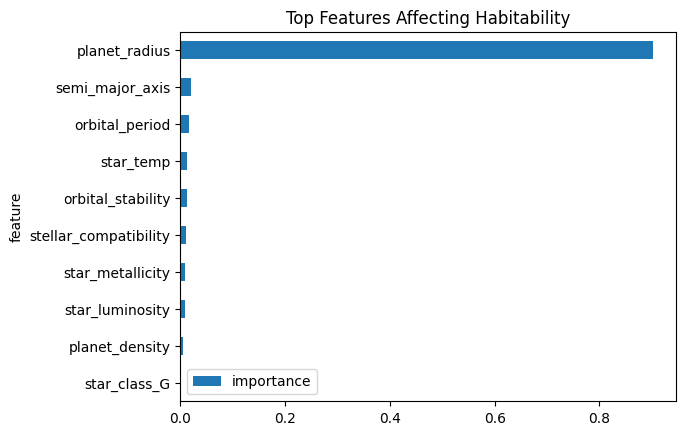

In [15]:
fi.head(10).plot(
    kind="barh",
    x="feature",
    y="importance",
    title="Top Features Affecting Habitability"
)

plt.gca().invert_yaxis()
plt.show()


Completion Message

In [16]:
print("ALL FILES GENERATED SUCCESSFULLY")


ALL FILES GENERATED SUCCESSFULLY
